# Image to code generation

In [1]:
from google.colab import drive 
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
# !unzip -u '/content/drive/My Drive/purecode/Assignment_Data.zip' -d '/content/drive/My Drive/purecode/dataset'

In [2]:
import tensorflow as tf 
print(tf.__version__)
import keras
keras.__version__

2.9.2


'2.9.0'

In [3]:
# imports
import os
from os import listdir
from numpy import array
import numpy as np
import cv2
import pandas as pd

from keras.preprocessing.text import Tokenizer, one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential, model_from_json
from keras.utils import to_categorical
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import Adam, RMSprop
from keras.layers.convolutional import Conv2D
from keras.layers import Embedding, TimeDistributed, RepeatVector, LSTM, concatenate, Input, Reshape,GRU
from keras.callbacks import ModelCheckpoint
# from keras_preprocessing.image import array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt 
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input



In [4]:
# paths for dataset
output_files= os.getcwd()+"/drive/My Drive/purecode/"
ds_train_imgs= os.getcwd()+"/drive/My Drive/purecode/dataset/D2/IMAGES/"
ds_train_labels= os.getcwd()+"/drive/My Drive/purecode/dataset/D2/TEXT_LABELS/"
# ds_val_imgs= os.getcwd()+"/drive/My Drive/purecode/dataset/D1/IMAGES/val/"
# ds_val_labels = os.getcwd()+"/drive/My Drive/purecode/dataset/D1/TEXT_LABELS/val/"
vocab_bootstrap= os.getcwd()+"/drive/My Drive/purecode/"



# Data preparation

In [5]:
all_images =[file for file in os.listdir(ds_train_imgs) if file.endswith('.png')]
all_images.sort()
print(len(all_images))
all_images[0]
len(all_images)

300


300

In [6]:
all_labels =[file for file in os.listdir(ds_train_labels) if file.endswith('.gui')]
all_labels.sort()
print(len(all_images))
all_labels[0]

300


'10408432.gui'

In [7]:
#read images and converted into numpy array
def load_images(img):  
  im = cv2.imread(img)    
  im= cv2.resize(im, (224, 224))
  return im

# read labels
def load_doc(input_label_file):
  file= open(input_label_file,'r')
  text = file.read()  
  # Load the tokens and rap them in a start and end tag
  text = ' ' + text + ' '
  # Seperate all the words with a single space
  text = ' '.join(text.split())
  # Add a space after each comma
  text = text.replace(',', ' ,')
  return text 


In [8]:
# vocablury creation
import glob
char_list = []
files_list = glob.glob(ds_train_labels+"*.gui")
files_list
for file_elem in files_list:
  char_list.append(load_doc(file_elem))
print(len(char_list))
char_list

listToStr = ' '.join([str(elem) for elem in char_list])
print(listToStr)

voc_D2= (set(listToStr.split()))
voc_D2=' '.join(voc_D2)
print(voc_D2)


300
header { page-title , search-bar , cart-link } sidebar { medium-title , radio , rating , icons } canvas-header { btn-active , btn-inactive , btn-inactive } row { quadruple { small-title , text , btn-green } quadruple { small-title , text , btn-green } quadruple { small-title , text , btn-red } quadruple { small-title , text , btn-orange } } header { page-title } sidebar { ck-box , radio , dropdn , slider , rating } canvas-header { btn-inactive , btn-inactive , btn-inactive , btn-inactive , btn-active } row { quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-green } quadruple { small-title , text , btn-red } } row { double { small-title , text , btn-red } double { small-title , text , btn-orange } } header { page-title , search-bar , burger-link } sidebar { slider , rating , icons } canvas-header { btn-inactive , btn-inactive , btn-active , btn-inactive , btn-inactive } row { quadruple { small-title , tex

In [9]:
# load data the images with labels
def load_data(images_path, labels_path):
  images_array = []
  labels_text = []
  all_images =[file for file in os.listdir(ds_train_imgs) if file.endswith('.png')]
  all_images.sort()
  all_labels =[file for file in os.listdir(ds_train_labels) if file.endswith('.gui')]
  all_labels.sort()
  for i in range (len(all_images)): 
    images_array.append(load_images(ds_train_imgs+all_images[i]))   
    labels_text.append(load_doc(ds_train_labels+all_labels[i]))
  images_array = np.array(images_array, dtype=np.dtype('float'))   
  images_array = preprocess_input(images_array)    
  return images_array,labels_text




In [10]:
# converting image and text 
img_array,img_labels=load_data(ds_train_imgs, ds_train_labels)

#Saving images and labels
df = pd.DataFrame(img_labels, columns=['text_labels_D2']) 
df.to_csv(output_files+"text_labels_list_D2.csv")
np.save(output_files+'images_array_D2', img_array)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_array, img_labels, test_size=0.05, random_state=42)

In [12]:
X_train.shape, len(y_train), X_test.shape, len(y_test)

((285, 224, 224, 3), 285, (15, 224, 224, 3), 15)

In [13]:
img_array.shape, len(img_labels)

((300, 224, 224, 3), 300)

In [14]:
img_array[0]

array([[[-10.939,   8.221,  27.32 ],
        [-10.939,   8.221,  27.32 ],
        [-10.939,   8.221,  27.32 ],
        ...,
        [-10.939,   8.221,  27.32 ],
        [-10.939,   8.221,  27.32 ],
        [-10.939,   8.221,  27.32 ]],

       [[-10.939,   8.221,  27.32 ],
        [-10.939,   8.221,  27.32 ],
        [-10.939,   8.221,  27.32 ],
        ...,
        [-10.939,   8.221,  27.32 ],
        [-10.939,   8.221,  27.32 ],
        [-10.939,   8.221,  27.32 ]],

       [[-10.939,   8.221,  27.32 ],
        [-10.939,   8.221,  27.32 ],
        [-10.939,   8.221,  27.32 ],
        ...,
        [-10.939,   8.221,  27.32 ],
        [-10.939,   8.221,  27.32 ],
        [-10.939,   8.221,  27.32 ]],

       ...,

       [[151.061, 138.221, 131.32 ],
        [151.061, 138.221, 131.32 ],
        [151.061, 138.221, 131.32 ],
        ...,
        [151.061, 138.221, 131.32 ],
        [151.061, 138.221, 131.32 ],
        [151.061, 138.221, 131.32 ]],

       [[151.061, 138.221, 131.32 ],
  

'header { page-title , search-bar } sidebar { ck-box , radio , dropdn , rating } canvas-header { btn-inactive , btn-inactive , btn-inactive , btn-inactive , btn-active } row { quadruple { small-title , text , btn-red } quadruple { small-title , text , btn-orange } quadruple { small-title , text , btn-green } quadruple { small-title , text , btn-orange } } row { double { small-title , text , btn-orange } double { small-title , text , btn-green } }'

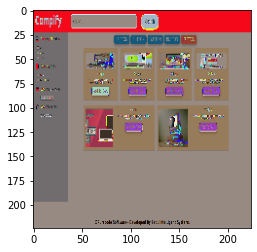

In [15]:
plt.imshow(img_array[0,:,:,:].astype('uint8'))
img_labels[0]

'header { search-bar , cart-link , burger-link } sidebar { medium-title , radio , dropdn , slider , rating } canvas-header { btn-active , btn-inactive , btn-inactive , btn-inactive , btn-inactive } row { single { small-title , text , btn-green } }'

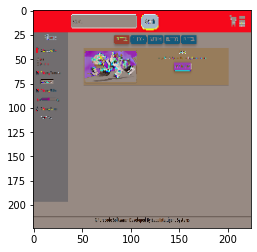

In [16]:
plt.imshow(X_test[0,:,:,:].astype('uint8'))
y_test[0]

['header', '{', 'page', '-', 'title', ',', 'search', '-', 'bar', '}', 'sidebar', '{', 'ck', '-', 'box', ',', 'radio', ',', 'dropdn', ',', 'rating', '}', 'canvas', '-', 'header', '{', 'btn', '-', 'active', ',', 'btn', '-', 'inactive', ',', 'btn', '-', 'inactive', ',', 'btn', '-', 'inactive', '}', 'row', '{', 'quadruple', '{', 'small', '-', 'title', ',', 'text', ',', 'btn', '-', 'red', '}', 'quadruple', '{', 'small', '-', 'title', ',', 'text', ',', 'btn', '-', 'red', '}', 'quadruple', '{', 'small', '-', 'title', ',', 'text', ',', 'btn', '-', 'red', '}', 'quadruple', '{', 'small', '-', 'title', ',', 'text', ',', 'btn', '-', 'red', '}', '}']


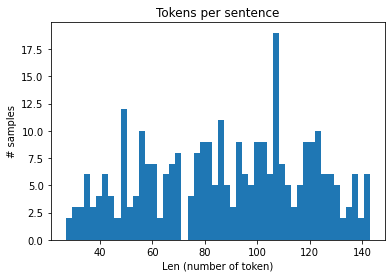

In [17]:
import re
import string

# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

print(tokenize(img_labels[1]))
# Plot sentence by lenght
plt.hist([len(tokenize(s)) for s in img_labels], bins=50)
plt.title('Tokens per sentence')
plt.xlabel('Len (number of token)')

plt.ylabel('# samples')
plt.show()

In [18]:
# Initialize the function to create the vocabulary 
tokenizer = Tokenizer(filters='', split=" ", lower=False)
# Create the vocabulary 
tokenizer.fit_on_texts([load_doc(vocab_bootstrap+'bootstrap_D2.vocab')])

# Add one spot for the empty word in the vocabulary 
VOCAB_SIZE = len(tokenizer.word_index) + 1


In [19]:
tokenizer.word_index 

{'<START>': 1,
 ',': 2,
 '{': 3,
 '}': 4,
 'page-title': 5,
 'header': 6,
 'small-title': 7,
 'radio': 8,
 'ck-box': 9,
 'btn-red': 10,
 'row': 11,
 'dropdn': 12,
 'btn-orange': 13,
 'burger-link': 14,
 'single': 15,
 'rating': 16,
 'cart-link': 17,
 'quadruple': 18,
 'canvas-header': 19,
 'text': 20,
 'btn-green': 21,
 'btn-active': 22,
 'double': 23,
 'search-bar': 24,
 'btn-inactive': 25,
 'icons': 26,
 'sidebar': 27,
 'medium-title': 28,
 'slider': 29,
 '<END>': 30}

In [20]:
#preprocessing the data
def preprocess_data(texts, images, max_sequence, MAX_lEN=50):
    X, y, image_data = list(), list(), list()
    sequences = tokenizer.texts_to_sequences(texts)
    for img_no, seq in enumerate(sequences):
        for i in range(1, len(seq)):
            # Add the sentence until the current count(i) and add the current count to the output
            in_seq, out_seq = seq[:i], seq[i]
            # Pad all the input token sentences to max_sequence
            in_seq = pad_sequences([in_seq], maxlen=max_sequence)[0]
            # Turn the output into one-hot encoding
            out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]
            # Add the corresponding image to the boostrap token file
            image_data.append(images[img_no])
            # Cap the input sentence to MAX_LEN tokens and add it
            MAX_LEN=50
            X.append(in_seq[-MAX_LEN:])
            y.append(out_seq)
    return np.array(image_data), np.array(X), np.array(y)

In [21]:
# Data generator, call to model.fit_generator()
def data_generator(descriptions, features, n_step, max_sequence, MAX_LEN):
    # loop until we finish training
    while 1:
        # loop over photo identifiers in the dataset
        for i in range(0, len(descriptions), n_step):
            Ximages, XSeq, y = list(), list(),list()
            for j in range(i, min(len(descriptions), i+n_step)):
                image = features[j]
                # retrieve text input
                desc = descriptions[j]
                # Generate input-output pairs
                in_img, in_seq, out_word = preprocess_data([desc], [image], max_sequence,MAX_LEN)
                for k in range(len(in_img)):
                    Ximages.append(in_img[k])
                    XSeq.append(in_seq[k])
                    y.append(out_word[k])
            # yield this batch of samples to the model
            yield [[array(Ximages), array(XSeq)], array(y)]

#Model

In [22]:
# Load the ResNet50 model trained on imagenet and output the classification feature
resnet = ResNet50(weights='imagenet', include_top=True)
# Extract the features from the train images
features= resnet.predict(X_train)

# Extract the features from the test images
features_test = resnet.predict(X_test)

print(features.shape)
print(features_test.shape)

1/1 [==============================] - 2s 2s/step
(285, 1000)
(15, 1000)


In [23]:
MAX_SEQUENCE =150  # The max sequence to predict
MAX_lEN = 50     # Max number of token for the input in the context prediction
# Load the feature to the network, apply a dense layer, and repeat the vector
resnet_feature = Input(shape=(1000,))
resnet_feature_dense = Dense(64)(resnet_feature)
resnet_feature_repeat = RepeatVector(MAX_lEN)(resnet_feature_dense)

# Extract information from the input seqence 
#Create the Text-encoder
language_input = Input(shape=(50,))
language_model = Embedding(VOCAB_SIZE, 50, input_length=MAX_lEN, mask_zero=True)(language_input)
language_model = GRU(64, return_sequences=True)(language_model)
language_model = GRU(64, return_sequences=True)(language_model)


In [24]:
# Concatenate the information from the image and the input
decoder = concatenate([resnet_feature_repeat, language_model])
# Extract information from the concatenated output
decoder = GRU(64, return_sequences=False)(decoder)
# Predict which word comes next
decoder_output = Dense(VOCAB_SIZE, activation='softmax')(decoder)
# Compile and run the neural network
model = Model(inputs=[resnet_feature, language_input], outputs=decoder_output)
optimizer=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)  #rmsprop

In [25]:
# Train the neural network
MAX_SEQUENCE=150
batch_size =64
history= model.fit(data_generator(y_train, features, 1, MAX_SEQUENCE,MAX_LEN=50), steps_per_epoch=len(y_train)//batch_size, batch_size=batch_size, shuffle=False, epochs=1500, verbose=1)

Epoch 1/1500
4/4 [==============================] - 13s 160ms/step - loss: 3.4029
Epoch 2/1500
4/4 [==============================] - 1s 150ms/step - loss: 3.3218
Epoch 3/1500
4/4 [==============================] - 1s 174ms/step - loss: 3.1362
Epoch 4/1500
4/4 [==============================] - 1s 150ms/step - loss: 2.9299
Epoch 5/1500
4/4 [==============================] - 1s 185ms/step - loss: 2.7910
Epoch 6/1500
4/4 [==============================] - 0s 127ms/step - loss: 2.8449
Epoch 7/1500
4/4 [==============================] - 1s 133ms/step - loss: 2.6878
Epoch 8/1500
4/4 [==============================] - 1s 151ms/step - loss: 2.7092
Epoch 9/1500
4/4 [==============================] - 1s 133ms/step - loss: 2.7199
Epoch 10/1500
4/4 [==============================] - 1s 124ms/step - loss: 2.6449
Epoch 11/1500
4/4 [==============================] - 1s 140ms/step - loss: 2.6306
Epoch 12/1500
4/4 [==============================] - 1s 146ms/step - loss: 2.6771
Epoch 13/1500
4/4 [=====

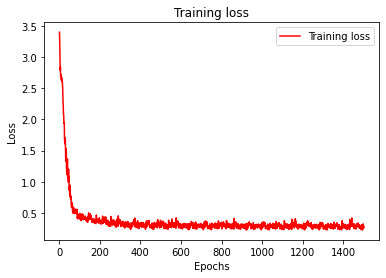

In [26]:
# Plotting training and validation loss for combined model
loss_values = history.history['loss']
# val_loss_values = history.history['val_loss']
epochs = range(1, len(history.history['loss'] )+ 1)
plt.plot(epochs, loss_values, 'r', label='Training loss')
# plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("com_model_loss.png")
plt.show()

In [27]:
#Save the model for every 2nd epoch

model.save(output_files+'pic2text_model_D2.h5')  # creates a HDF5 file 'my_model.h5'

# Evaluate model

In [28]:
from keras.saving.save import load_model
model= load_model(output_files+'pic2text_model_D2.h5')

In [29]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    photo = np.array([photo])
    # seed the generation process
    in_text = ' '
    # iterate over the whole length of the sequence
    print('\nPrediction---->\n\n ', end='')
    for i in range(180):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo, sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += word + ' '
        # stop if we predict the end of the sequence
        print(word + ' ', end='')
        if word == '':
            break
    return in_text

In [30]:
from nltk.translate.bleu_score import corpus_bleu

# Evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for i in range(len(descriptions)):
        yhat = generate_desc(model, tokenizer, photos[i], max_length)
        # store actual and predicted
        print('\n\nReal---->\n\n' + y_test[i])
        actual.append([y_test[i].split()])
        predicted.append(yhat.split())
    # calculate BLEU score
    bleu = corpus_bleu(actual, predicted)
    return bleu, actual, predicted

# Eval on the first 10 samples
# bleu, actual, predicted = evaluate_model(model, texts[:10], train_features[:10], tokenizer, MAX_LEN)
bleu, actual, predicted = evaluate_model(model, y_test, features_test, tokenizer, 50)
print("BLUE score: ", bleu)


Prediction---->

 } { single { small-title , text , btn-red } } row { single { small-title , text , btn-red } } row { single { small-title , text , btn-red } } row { single { small-title , text , btn-red } } row { single { small-title , text , btn-red } } row { single { small-title , text , btn-red } } row { single { small-title , text , btn-red } } row { single { small-title , text , btn-red } } row { single { small-title , text , btn-red } } row { single { small-title , text , btn-red } } row { single { small-title , text , btn-red } } row { single { small-title , text , btn-red } } row { single { small-title , text , btn-red } } row { single { small-title , text , btn-red } } row { single { small-title , text , btn-red } } row { single { small-title , text , btn-red } } row { single { 

Real---->

header { search-bar , cart-link , burger-link } sidebar { medium-title , radio , dropdn , slider , rating } canvas-header { btn-active , btn-inactive , btn-inactive , btn-inactive , btn-i